In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
DATASET_DIRECTORY = 'CICIoT2023MergeData/'

In [3]:
# 获取目录中所有以 .csv 结尾的文件名
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]

# 初始化一个空列表存储 DataFrame
dataframes = []

# 使用 tqdm 遍历文件列表并读取每个 CSV 文件
for file in tqdm(df_sets, desc="Reading CSV files"):
    filepath = os.path.join(DATASET_DIRECTORY, file)
    # 读取 CSV 文件并将其添加到列表中
    dataframes.append(pd.read_csv(filepath))

# 使用 concat 函数将所有 DataFrame 合并为一个
merged_df = pd.concat(dataframes, ignore_index=True)

Reading CSV files: 100%|█████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.06s/it]


In [4]:
# 打印合并后的 DataFrame 大小
print("Merged DataFrame shape:", merged_df.shape)

Merged DataFrame shape: (2196390, 47)


In [5]:
# X是特征，y是目标变量（如果有的话）
X = merged_df[['flow_duration','Header_Length','ack_flag_number','urg_count','rst_count','Max','AVG','Std','Tot size','Magnitue','Variance']] # 特征
y = merged_df['label']  # 目标变量

In [6]:
X

,flow_duration,Header_Length,ack_flag_number,urg_count,rst_count,Max,AVG,Std,Tot size,Magnitue,Variance
0,4.301325,150.66,0.0,0.0,0.0,54.00,54.000000,0.000000,54.00,10.392305,0.00
1,0.000000,55.17,1.0,1.0,1.0,73.89,56.064355,5.833132,55.17,10.578951,0.17
2,0.000000,54.00,0.0,0.0,0.0,54.00,54.000000,0.000000,54.00,10.392305,0.00
3,0.000286,55.40,0.0,0.0,0.0,55.38,54.079621,0.321334,54.23,10.399977,0.06
4,0.000000,54.00,0.0,0.0,0.0,54.00,54.000000,0.000000,54.00,10.392305,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2196385,0.732928,2250732.00,1.0,558.4,2039.4,2305.20,806.375397,836.076446,917.60,38.208551,0.80
2196386,13.401717,11497.60,1.0,28.8,62.1,228.00,109.149127,64.519729,108.20,14.697835,0.90
2196387,9.528512,116067.30,0.0,76.8,240.5,644.60,209.353413,187.924704,337.50,19.810382,0.90
2196388,16.250675,85094.50,1.0,7.3,87.7,2962.00,613.377723,857.873462,105.80,34.988182,1.00


In [7]:
y

0          0
1          0
2          0
3          0
4          0
          ..
2196385    1
2196386    1
2196387    1
2196388    1
2196389    1
Name: label, Length: 2196390, dtype: int64

In [8]:
y.value_counts()

label
0    1098195
1    1098195
Name: count, dtype: int64

In [9]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [10]:
# 按比例（例如80%训练集，20%测试集）分割数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 打印训练集和测试集的大小
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 1757112
Testing set size: 439278


In [11]:
y_train.shape, X_train.shape

((1757112,), (1757112, 11))

In [12]:
import tensorflow as tf

# 定义模型
model = tf.keras.Sequential([
    # 第一层：卷积层
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(11, 1)),  # 修改 input_shape

    # 第二层：最大池化层
    tf.keras.layers.MaxPooling1D(pool_size=1),

    # 第三层：批量归一化层
    tf.keras.layers.BatchNormalization(),

    # 第四层：LSTM 层
    tf.keras.layers.LSTM(units=64, return_sequences=True),

    # 第五层：Dropout 层
    tf.keras.layers.Dropout(0.2),

    # 重复上述层三次
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.Dropout(0.4),

    # 全连接层
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=2, activation='softmax')  # 2 是分类数，使用 Softmax 激活函数
])

# 编译模型
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 打印模型概要
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 32)            128       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 9, 64)             24832     
                                                                 
 dropout (Dropout)           (None, 9, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             1

In [14]:
# 训练模型
input_data_reshape = X_train.reshape((-1, 11, 1))

# # 假设 df 是你的 DataFrame 变量
# data = X_train.values  # 将 DataFrame 转换为 numpy 数组
# data_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 在第三维度添加一个维度


In [15]:
model.fit(
    tf.convert_to_tensor(input_data_reshape),
    y_train, 
    epochs=10,
    batch_size = 256
)

Epoch 1/10
6864/6864 [==============================] - 170s 22ms/step - loss: 0.0435 - accuracy: 0.9889
Epoch 2/10
6864/6864 [==============================] - 134s 19ms/step - loss: 0.0369 - accuracy: 0.9904
Epoch 3/10
6864/6864 [==============================] - 143s 21ms/step - loss: 0.0347 - accuracy: 0.9910
Epoch 4/10
6864/6864 [==============================] - 152s 22ms/step - loss: 0.0332 - accuracy: 0.9914
Epoch 5/10
6864/6864 [==============================] - 156s 23ms/step - loss: 0.0322 - accuracy: 0.9917
Epoch 6/10
6864/6864 [==============================] - 156s 23ms/step - loss: 0.0315 - accuracy: 0.9919
Epoch 7/10
6864/6864 [==============================] - 141s 21ms/step - loss: 0.0310 - accuracy: 0.9921
Epoch 8/10
6864/6864 [==============================] - 149s 22ms/step - loss: 0.0304 - accuracy: 0.9922
Epoch 9/10
6864/6864 [==============================] - 145s 21ms/step - loss: 0.0301 - accuracy: 0.9923
Epoch 10/10
6864/6864 [==============================] 

In [16]:
# 使用模型进行预测
predictions = model.predict(X_test)

13728/13728 [==============================] - 95s 7ms/step


In [17]:
# 获取预测结果中概率最高的类别
predicted_labels = np.argmax(predictions, axis=1)

# 计算模型的准确率
accuracy = np.mean(predicted_labels == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9888498854939242


In [18]:
tf.math.confusion_matrix(labels=y_test, predictions=predicted_labels)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[216970,   2681],
       [  2217, 217410]])>

In [19]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print('accuracy_score: ', accuracy_score(predicted_labels, y_test))
print('recall_score: ', recall_score(predicted_labels, y_test, average='macro'))
print('precision_score: ', precision_score(predicted_labels, y_test, average='macro'))
print('f1_score: ', f1_score(predicted_labels, y_test, average='macro'))

accuracy_score:  0.9888498854939242
recall_score:  0.9888520120212367
precision_score:  0.9888499431705404
f1_score:  0.9888498743071155


In [20]:
model.save('my_model3.h5')

In [21]:
model.save('saved_model3', save_format='tf')

INFO:tensorflow:Assets written to: saved_model3\assets


INFO:tensorflow:Assets written to: saved_model3\assets


In [22]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('out.png', bbox_inches='tight')

Confusion matrix, without normalization


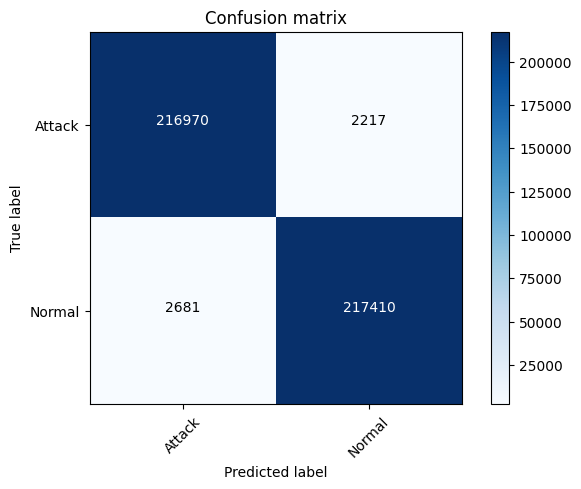

In [24]:
from sklearn import metrics
import itertools
# predictions2 = np.argmax(predicted_labels, axis=-1)

cm = metrics.confusion_matrix(predicted_labels, y_test)
plot_confusion_matrix(cm, classes=['Attack','Normal'])